In [1]:
import os
os.chdir("../")

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from collections import Counter
from code_base.functions import train, train_models, select_best_model, evaluate_performance
from code_base.models import LocalNet1, LocalNet2
from code_base.DataAnalysis import DataAnalysis

In [3]:
SEED = 265
torch.manual_seed(SEED)

DEVICE = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Using device: {DEVICE}")

Using device: cuda


# Object Localization

## Data exploration

In [4]:
# Loading the data as PyTorch Tensor Dataset
data_train = torch.load("data/localization_train.pt")
data_val = torch.load("data/localization_val.pt")
data_test = torch.load("data/localization_test.pt")
print("Type: ", type(data_train))

Type:  <class 'torch.utils.data.dataset.TensorDataset'>


In [5]:
DataAnalysis.get_summary(data_train)

Type of images in dataset: <class 'torch.Tensor'>
First image in dataset: tensor([[[0.3647, 0.2938, 0.2765,  ..., 0.3936, 0.3678, 0.5296],
         [0.2512, 0.2223, 0.3063,  ..., 0.4712, 0.3880, 0.3778],
         [0.2182, 0.1546, 0.3569,  ..., 0.6240, 0.3413, 0.4354],
         ...,
         [0.6697, 0.6960, 0.2436,  ..., 0.3731, 0.5221, 0.4018],
         [0.8009, 0.6783, 0.4918,  ..., 0.5213, 0.3627, 0.2501],
         [0.8217, 0.7294, 0.3937,  ..., 0.6089, 0.1960, 0.3527]]])
First data label (a vector of P_c, box_x_pos, box_y_pos, box_height, box_width, class label):  tensor([1.0000, 0.6000, 0.2292, 0.3667, 0.4167, 4.0000])
Dataset size: 59400
Dataset shape: torch.Size([59400, 1, 48, 60])
Image shape: torch.Size([1, 48, 60])

----- Dataset class distribution (-1 for no object) -----
Class -1: 5400 examples
Class 0: 5345 examples
Class 1: 6075 examples
Class 2: 5365 examples
Class 3: 5522 examples
Class 4: 5243 examples
Class 5: 4889 examples
Class 6: 5310 examples
Class 7: 5644 example

In [6]:
DataAnalysis.get_summary(data_val)

Type of images in dataset: <class 'torch.Tensor'>
First image in dataset: tensor([[[0.6313, 0.7533, 0.6194,  ..., 0.4337, 0.4831, 0.3022],
         [0.7073, 0.4611, 0.5142,  ..., 0.5610, 0.5517, 0.5982],
         [0.6114, 0.4698, 0.4360,  ..., 0.6417, 0.4758, 0.4271],
         ...,
         [0.4714, 0.5969, 0.3056,  ..., 0.4580, 0.4583, 0.2852],
         [0.6684, 0.4994, 0.5108,  ..., 0.4111, 0.4682, 0.4607],
         [0.5233, 0.5018, 0.3971,  ..., 0.4283, 0.2382, 0.1903]]])
First data label (a vector of P_c, box_x_pos, box_y_pos, box_height, box_width, class label):  tensor([1.0000, 0.6167, 0.6250, 0.3667, 0.4583, 5.0000])
Dataset size: 6600
Dataset shape: torch.Size([6600, 1, 48, 60])
Image shape: torch.Size([1, 48, 60])

----- Dataset class distribution (-1 for no object) -----
Class -1: 600 examples
Class 0: 578 examples
Class 1: 667 examples
Class 2: 593 examples
Class 3: 609 examples
Class 4: 599 examples
Class 5: 532 examples
Class 6: 608 examples
Class 7: 621 examples
Class 8: 

In [7]:
DataAnalysis.get_summary(data_test)

Type of images in dataset: <class 'torch.Tensor'>
First image in dataset: tensor([[[0.2210, 0.4416, 0.3534,  ..., 0.5535, 0.6887, 0.5598],
         [0.2845, 0.3973, 0.3458,  ..., 0.4800, 0.5693, 0.5542],
         [0.2051, 0.3117, 0.1947,  ..., 0.4572, 0.4547, 0.4019],
         ...,
         [0.2451, 0.3729, 0.2737,  ..., 0.0782, 0.1691, 0.0667],
         [0.3223, 0.3826, 0.3099,  ..., 0.2794, 0.2301, 0.0541],
         [0.2335, 0.4308, 0.3738,  ..., 0.1801, 0.1865, 0.0000]]])
First data label (a vector of P_c, box_x_pos, box_y_pos, box_height, box_width, class label):  tensor([1.0000, 0.4000, 0.2188, 0.2667, 0.2292, 5.0000])
Dataset size: 11000
Dataset shape: torch.Size([11000, 1, 48, 60])
Image shape: torch.Size([1, 48, 60])

----- Dataset class distribution (-1 for no object) -----
Class -1: 1000 examples
Class 0: 980 examples
Class 1: 1135 examples
Class 2: 1032 examples
Class 3: 1010 examples
Class 4: 982 examples
Class 5: 892 examples
Class 6: 958 examples
Class 7: 1028 examples
Cl

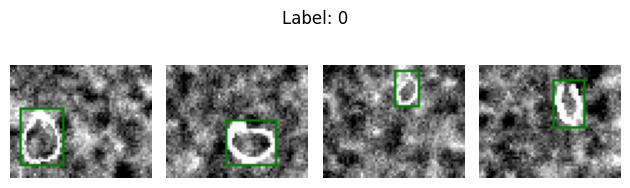

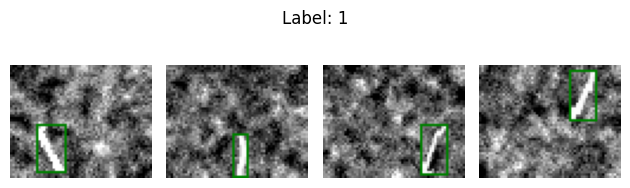

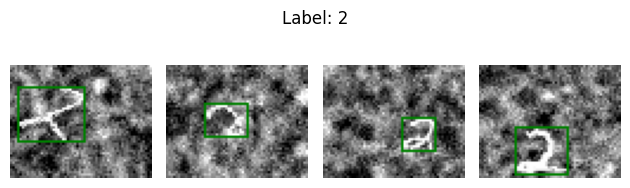

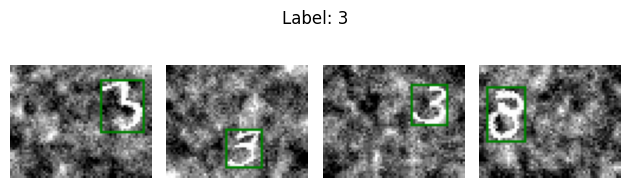

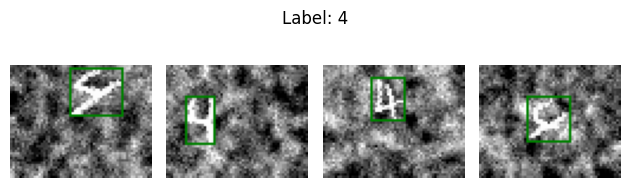

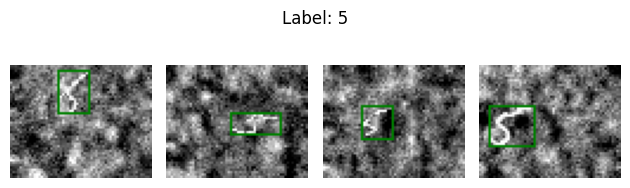

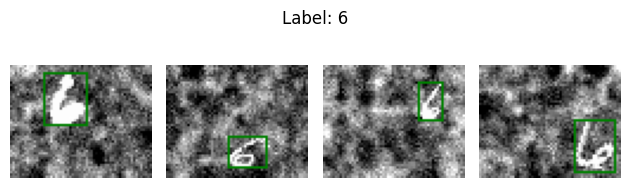

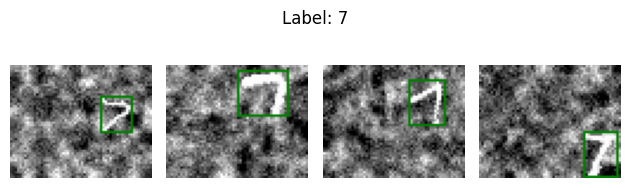

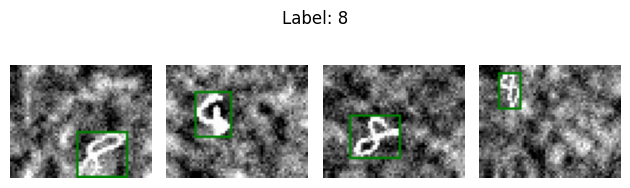

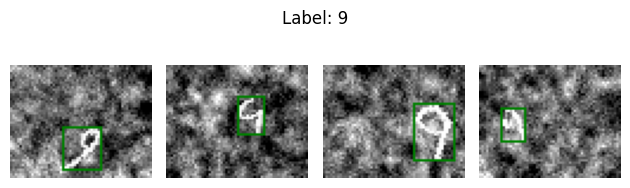

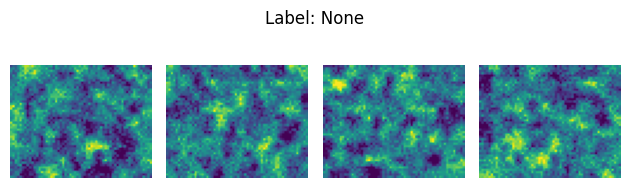

In [8]:
# Display 4 instances of each class
n_classes = len(Counter([int(label[-1]) for _, label in data_train]))
for i in range(n_classes):
    DataAnalysis.plot_instances_with_bounding_box(data_train, i, n_instances=4, save_to_file=f"imgs/localization/true_instances/class_{i}.png")
# No class
DataAnalysis.plot_instances_with_bounding_box(data_train, None, n_instances=4, save_to_file="imgs/localization/true_instances/class_none.png")

## Training

In [9]:
# Normalize from training data
imgs = torch.stack([img for img, _ in data_train])

# Define normalizer
normalizer = transforms.Normalize(
    imgs.mean(dim=(0, 2, 3)), 
    imgs.std(dim=(0, 2, 3))
    )

data_train_norm = [(normalizer(img), label) for img, label in data_train]
data_val_norm = [(normalizer(img), label) for img, label in data_val]
data_test_norm = [(normalizer(img), label) for img, label in data_test]

In [10]:
batch_size = 64
torch.manual_seed(SEED)
train_loader = DataLoader(data_train_norm, batch_size=batch_size, shuffle=True)
torch.manual_seed(SEED)
val_loader = DataLoader(data_val_norm, batch_size=batch_size, shuffle=True)

In [11]:
epochs = 50
early_stop_patience = 7
networks = [LocalNet1, LocalNet2]

hyper_parameters = [
    {"lr": 0.001, "weight_decay": 0.0},
    {"lr": 0.001, "weight_decay": 0.0005},
    {"lr": 0.01, "weight_decay": 0.0},
    {"lr": 0.01, "weight_decay": 0.0001},
    {"lr": 0.005, "weight_decay": 0.0001},
]

In [12]:
results = train_models(
    "localization",
    networks,
    hyper_parameters,
    batch_size,
    epochs,
    train_loader,
    val_loader,
    DEVICE,
    SEED,
    early_stop_patience
)

	Global parameters:
Batch size: 64
Epochs: 50
Seed: 265

Model architecture: <class 'code_base.models.LocalNet1'>

	Current parameters: 
lr:0.001
weight_decay:0.0
Starting training for localization using above parameters:


| 20:18:40.623267 | Epoch: 1 | train_loss: 2.189 | val_loss: 1.878 |
training: | Box accuracy: 2.320% | Detection accuracy: 94.215% | Mean accuracy: 48.268% | Strict accuracy: 6.039% |
validation: | Box accuracy: 4.828% | Detection accuracy: 98.667% | Mean accuracy: 51.747% | Strict accuracy: 12.939% |

| 20:20:02.590604 | Epoch: 10 | train_loss: 0.958 | val_loss: 1.019 |
training: | Box accuracy: 28.566% | Detection accuracy: 99.815% | Mean accuracy: 64.190% | Strict accuracy: 34.966% |
validation: | Box accuracy: 27.207% | Detection accuracy: 99.621% | Mean accuracy: 63.414% | Strict accuracy: 33.667% |
__Stopping training in 6 epochs
__Stopping training in 5 epochs
__Stopping training in 4 epochs

| 20:22:09.626307 | Epoch: 20 | train_loss: 0.404 | val_loss: 0.91

In [13]:
best_model, best_model_idx = select_best_model(results["models"], results["strict_val"])
print(best_model)

LocalNet2(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (max_pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=960, out_features=960, bias=True)
  (fc2): Linear(in_features=960, out_features=320, bias=True)
  (fc3): Linear(in_features=320, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=15, bias=True)
)


In [14]:
bm_hyper_params = results["hyper_params"][best_model_idx]
bm_train_loss = results["loss_train"][best_model_idx]
bm_val_loss = results["loss_val"][best_model_idx]
bm_train_strict_acc = results["strict_train"][best_model_idx]
bm_val_strict_acc = results["strict_val"][best_model_idx]
bm_train_box_acc = results["box_train"][best_model_idx]
bm_val_box_acc = results["box_val"][best_model_idx]
bm_train_detect_acc = results["detection_train"][best_model_idx]
bm_val_detect_acc = results["detection_val"][best_model_idx]
bm_train_mean_acc = results["mean_perf_train"][best_model_idx]
bm_val_mean_acc = results["mean_perf_val"][best_model_idx]

Selected hyper parameters
{'lr': 0.001, 'weight_decay': 0.0005}


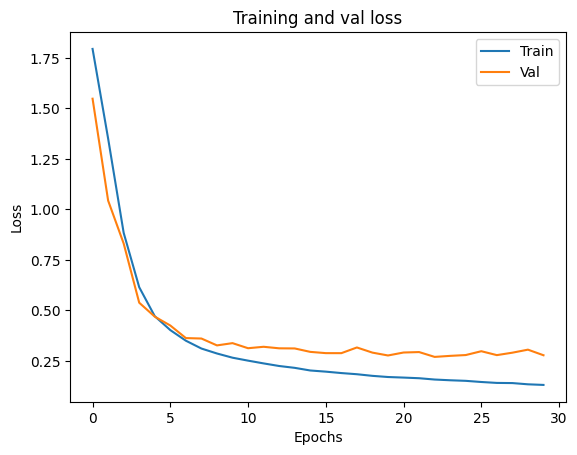

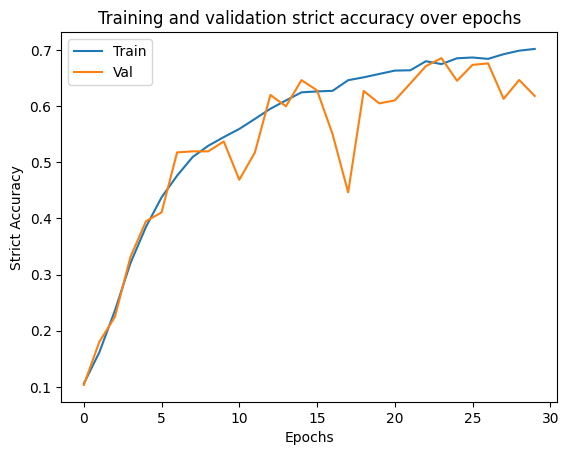

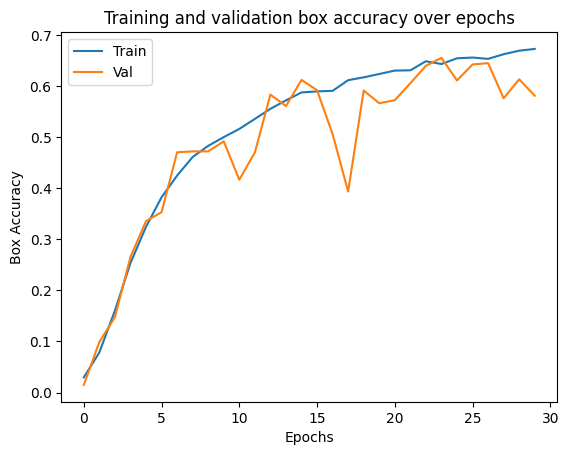

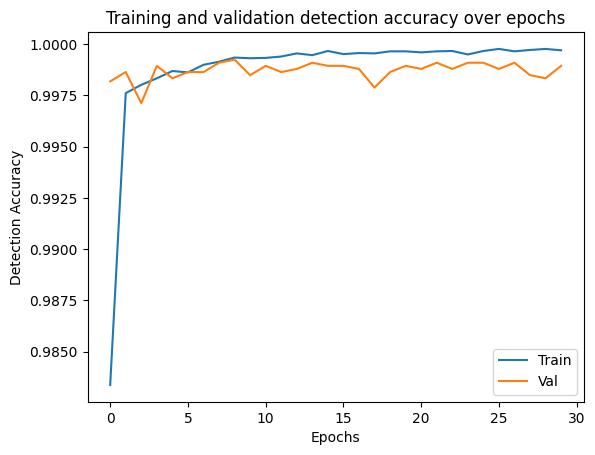

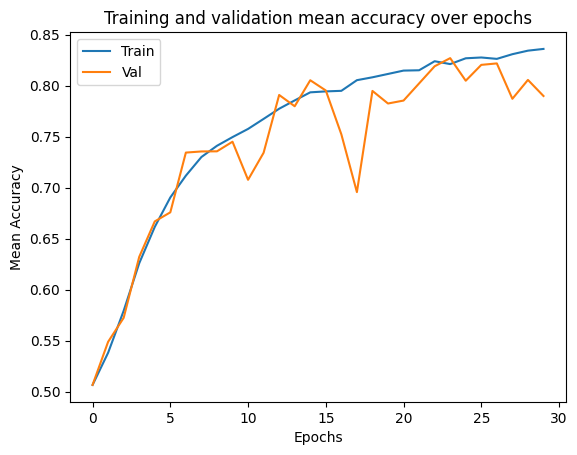

In [15]:
# Hyper parameters
print("Selected hyper parameters")
print(bm_hyper_params)

# Loss
DataAnalysis.plot_performance_over_time(bm_train_loss, bm_val_loss, "Training and val loss", y_label="Loss",
                                        save_to_file="imgs/localization/performance/loss.png")

# Strict accuracy
DataAnalysis.plot_performance_over_time(bm_train_strict_acc, bm_val_strict_acc, "Training and validation strict accuracy over epochs", y_label="Strict Accuracy",
                                        save_to_file="imgs/localization/performance/strict.png") 

# Box accuracy
DataAnalysis.plot_performance_over_time(bm_train_box_acc, bm_val_box_acc, "Training and validation box accuracy over epochs", y_label="Box Accuracy",
                                        save_to_file="imgs/localization/performance/box.png") 
# Detection accuracy
DataAnalysis.plot_performance_over_time(bm_train_detect_acc, bm_val_detect_acc, "Training and validation detection accuracy over epochs", y_label="Detection Accuracy",
                                        save_to_file="imgs/localization/performance/detection.png")
# Mean accuracy
DataAnalysis.plot_performance_over_time(bm_train_mean_acc, bm_val_mean_acc, "Training and validation mean accuracy over epochs", y_label="Mean Accuracy",
                                        save_to_file="imgs/localization/performance/mean.png")

## Evaluation

In [20]:
torch.manual_seed(SEED)
test_loader = DataLoader(data_test_norm, batch_size=batch_size, shuffle=True)

perf, output = evaluate_performance("localization", best_model, test_loader, device=DEVICE)
print("--- Test performances ---")
print(f"Strict performance: {perf['strict']*100:.2f}%")
print(f"Box performance: {perf['box']*100:.2f}%")
print(f"Detection performance: {perf['detection']*100:.2f}%")
print(f"Mean performance: {perf['mean']*100:.2f}%")

--- Test performances ---
Strict performance: 62.23%
Box performance: 58.55%
Detection performance: 99.85%
Mean performance: 79.20%


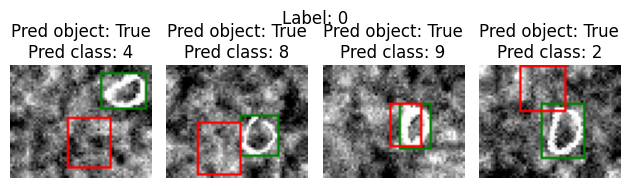

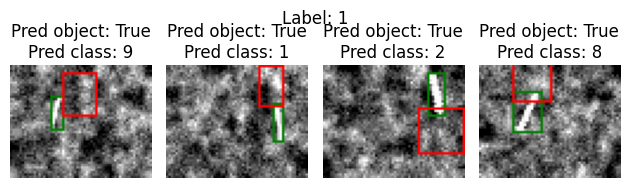

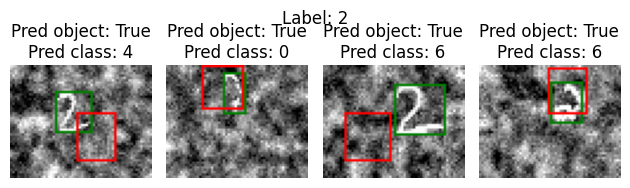

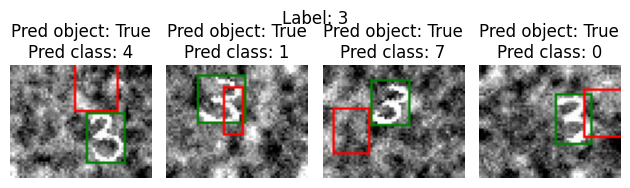

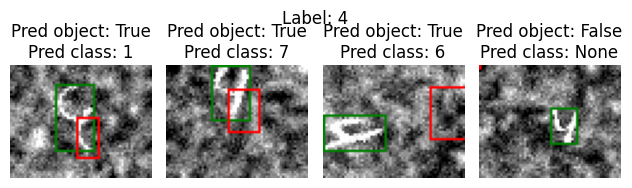

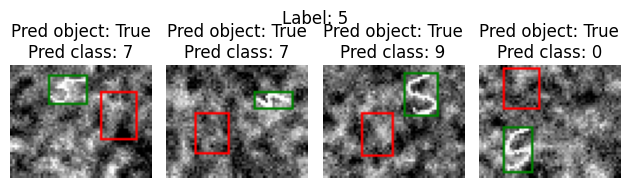

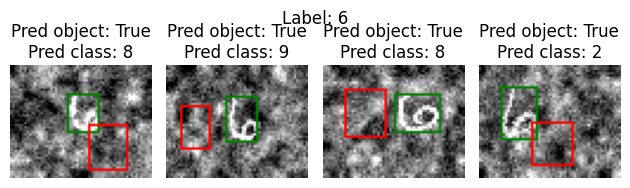

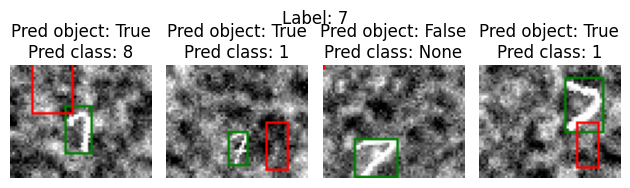

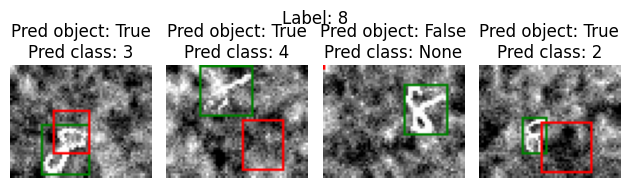

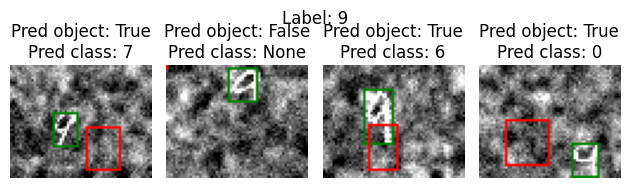

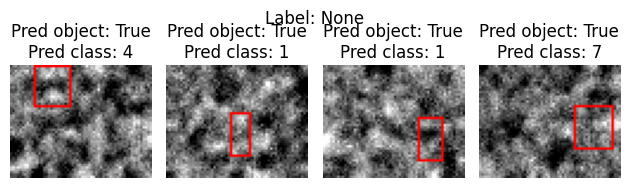

In [21]:
for i in range(10):
    DataAnalysis.plot_instances_with_bounding_box(data_test, i, predictions=output, save_to_file=f"imgs/localization/predictions/class_{i}.png")
DataAnalysis.plot_instances_with_bounding_box(data_test, None, predictions=output, save_to_file="imgs/localization/predictions/class_none.png")